In [1]:
pip install tensorflow numpy pandas matplotlib opencv-python scikit-learn


  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/ec/6c/fab8113424af5049f85717e8e527ca3773299a3c6b02506e66436e19874f/opencv_python-4.10.0.84-cp37-abi3-win_amd64.whl.metadata
  Obtaining dependency information for tensorflow-intel==2.18.0 from https://files.pythonhosted.org/packages/76/ad/fa6c508a15ff79cb5409294c293388e0999b7d480f84b65e4287277434fe/tensorflow_intel-2.18.0-cp311-cp311-win_amd64.whl.metadata
  Using cached tensorflow_intel-2.18.0-cp311-cp311-win_amd64.whl.metadata (4.9 kB)
  Obtaining dependency information for tensorboard<2.19,>=2.18 from https://files.pythonhosted.org/packages/b1/de/021c1d407befb505791764ad2cbd56ceaaa53a746baed01d2e2143f05f18/tensorboard-2.18.0-py3-none-any.whl.metadata
  Using cached tensorboard-2.18.0-py3-none-any.whl.metadata (1.6 kB)
Using cached tensorflow_intel-2.18.0-cp311-cp311-win_amd64.whl (390.2 MB)
   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   -----------------------

Classes: ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']


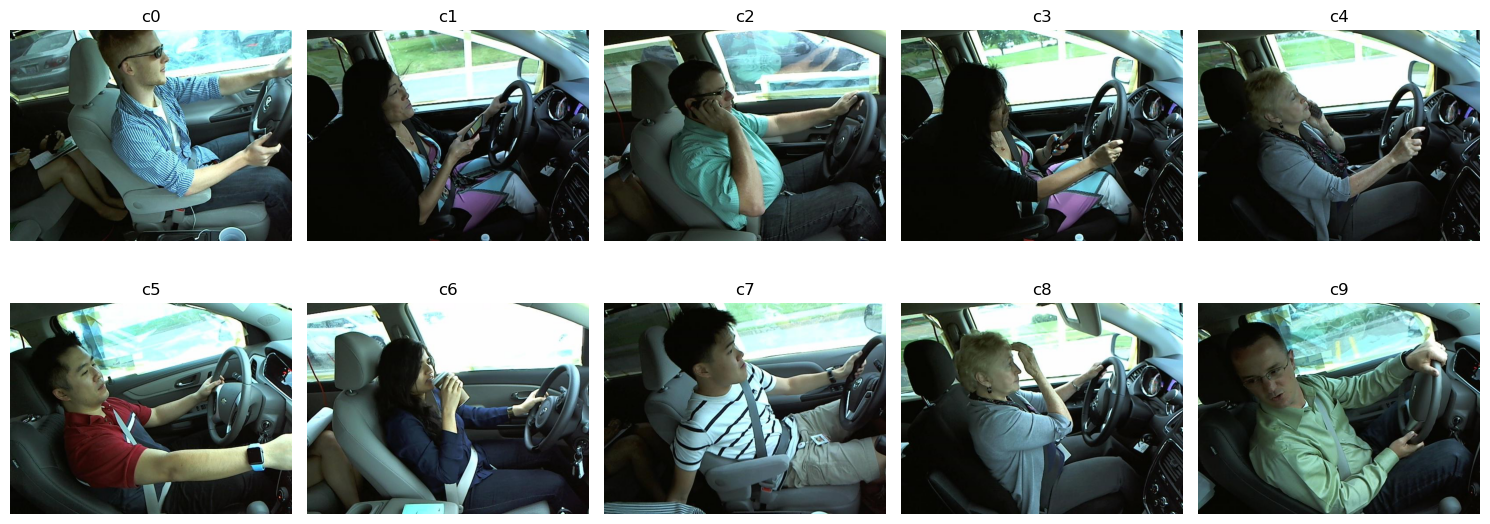

In [3]:
import os
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image

# Define dataset paths
dataset_path = r"C:\Users\Aavneet Singh Johar\IIT_Kanpur_Edvancer\Python\Deep Learning projects\Project 4\state-farm-distracted-driver-detection"
train_path = os.path.join(dataset_path, 'imgs', 'train')
test_path = os.path.join(dataset_path, 'imgs', 'test')

# List classes
classes = sorted(os.listdir(train_path))
print("Classes:", classes)

# Display a few sample images
def display_sample_images():
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    for i, class_name in enumerate(classes):
        image_path = glob(os.path.join(train_path, class_name, "*.jpg"))[0]  # Take the first image of each class
        image = Image.open(image_path)
        ax = axes[i // 5, i % 5]
        ax.imshow(image)
        ax.set_title(class_name)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

display_sample_images()


In [5]:
import pandas as pd  
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Parameters
image_size = (128, 128)  # Resize images to this size
batch_size = 32

# Prepare file paths and labels
image_paths = []
labels = []
for class_name in classes:
    class_folder = os.path.join(train_path, class_name)
    images = glob(os.path.join(class_folder, "*.jpg"))
    image_paths.extend(images)
    labels.extend([class_name] * len(images))

# Split into train and validation sets
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42
)

print(f"Total images: {len(image_paths)}")
print(f"Training images: {len(train_paths)}")
print(f"Validation images: {len(val_paths)}")

# Data generators for train and validation sets
train_datagen = ImageDataGenerator(rescale=1.0/255.0, horizontal_flip=True, rotation_range=15)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({"filename": train_paths, "class": train_labels}),
    x_col="filename",
    y_col="class",
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical"
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({"filename": val_paths, "class": val_labels}),
    x_col="filename",
    y_col="class",
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical"
)


Total images: 22424
Training images: 17939
Validation images: 4485
Found 17939 validated image filenames belonging to 10 classes.
Found 4485 validated image filenames belonging to 10 classes.


In [6]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

# Load the base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model layers
base_model.trainable = False

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling
x = Dropout(0.5)(x)  # Add dropout for regularization
x = Dense(128, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)  # 10 classes

# Create the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 64, 64, 32)        │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 64, 64, 32)        │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 64, 64, 32)        │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 64, 64, 32)        │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 64, 64, 32)        │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 64, 64, 32)        │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 64, 64, 16)        │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 64, 64, 16)        │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 64, 64, 96)        │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 64, 64, 96)        │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 64, 64, 96)        │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 65, 65, 96)        │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 32, 32, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,423,242 (9.24 MB)

 Trainable params: 165,258 (645.54 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define callbacks
checkpoint = ModelCheckpoint("best_model.h5", monitor="val_accuracy", save_best_only=True, mode="max")
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20, 
    callbacks=[checkpoint, early_stopping],
    verbose=1
)

E:\Anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
561/561 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - accuracy: 0.3417 - loss: 1.9412

561/561 ━━━━━━━━━━━━━━━━━━━━ 364s 637ms/step - accuracy: 0.3419 - loss: 1.9405 - val_accuracy: 0.6644 - val_loss: 0.9979
Epoch 2/20
561/561 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.6247 - loss: 1.0920

561/561 ━━━━━━━━━━━━━━━━━━━━ 295s 526ms/step - accuracy: 0.6247 - loss: 1.0919 - val_accuracy: 0.7534 - val_loss: 0.7679
Epoch 3/20
561/561 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.6960 - loss: 0.8803

561/561 ━━━━━━━━━━━━━━━━━━━━ 303s 540ms/step - accuracy: 0.6961 - loss: 0.8802 - val_accuracy: 0.7759 - val_loss: 0.6724
Epoch 4/20
561/561 ━━━━━━━━━━━━━━━━━━━━ 290s 518ms/step - accuracy: 0.7324 - loss: 0.7917 - val_accuracy: 0.7746 - val_loss: 0.6733
Epoch 5/20
561/561 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.7694 - loss: 0.6798

561/561 ━━━━━━━━━━━━━━━━━━━━ 288s 513ms/step - accuracy: 0.7694 - loss: 0.6798 - val_accuracy: 0.8573 - val_loss: 0.4678
Epoch 6/20
561/561 ━━━━━━━━━━━━━━━━━━━━ 6412s 11s/step - accuracy: 0.7957 - loss: 0.6118 - val_accuracy: 0.8366 - val_loss: 0.4894
Epoch 7/20
561/561 ━━━━━━━━━━━━━━━━━━━━ 303s 540ms/step - accuracy: 0.8039 - loss: 0.5833 - val_accuracy: 0.8524 - val_loss: 0.4487
Epoch 8/20
561/561 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.8163 - loss: 0.5440

561/561 ━━━━━━━━━━━━━━━━━━━━ 289s 516ms/step - accuracy: 0.8163 - loss: 0.5440 - val_accuracy: 0.8957 - val_loss: 0.3570
Epoch 9/20
561/561 ━━━━━━━━━━━━━━━━━━━━ 331s 591ms/step - accuracy: 0.8374 - loss: 0.4914 - val_accuracy: 0.8919 - val_loss: 0.3576
Epoch 10/20
561/561 ━━━━━━━━━━━━━━━━━━━━ 1764s 3s/step - accuracy: 0.8346 - loss: 0.4914 - val_accuracy: 0.8939 - val_loss: 0.3464
Epoch 11/20
561/561 ━━━━━━━━━━━━━━━━━━━━ 337s 602ms/step - accuracy: 0.8569 - loss: 0.4317 - val_accuracy: 0.8892 - val_loss: 0.3501
Epoch 12/20
561/561 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.8570 - loss: 0.4301

561/561 ━━━━━━━━━━━━━━━━━━━━ 284s 506ms/step - accuracy: 0.8570 - loss: 0.4301 - val_accuracy: 0.9023 - val_loss: 0.3184
Epoch 13/20
561/561 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.8533 - loss: 0.4311

561/561 ━━━━━━━━━━━━━━━━━━━━ 296s 527ms/step - accuracy: 0.8533 - loss: 0.4311 - val_accuracy: 0.9088 - val_loss: 0.2955
Epoch 14/20
561/561 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.8625 - loss: 0.4103

561/561 ━━━━━━━━━━━━━━━━━━━━ 305s 544ms/step - accuracy: 0.8625 - loss: 0.4103 - val_accuracy: 0.9162 - val_loss: 0.2752
Epoch 15/20
561/561 ━━━━━━━━━━━━━━━━━━━━ 297s 530ms/step - accuracy: 0.8713 - loss: 0.3869 - val_accuracy: 0.9001 - val_loss: 0.2989
Epoch 16/20
561/561 ━━━━━━━━━━━━━━━━━━━━ 281s 501ms/step - accuracy: 0.8699 - loss: 0.3798 - val_accuracy: 0.9090 - val_loss: 0.2964
Epoch 17/20
561/561 ━━━━━━━━━━━━━━━━━━━━ 1461s 3s/step - accuracy: 0.8811 - loss: 0.3579 - val_accuracy: 0.9155 - val_loss: 0.2773
Epoch 18/20
561/561 ━━━━━━━━━━━━━━━━━━━━ 289s 515ms/step - accuracy: 0.8799 - loss: 0.3586 - val_accuracy: 0.9139 - val_loss: 0.2656
Epoch 19/20
561/561 ━━━━━━━━━━━━━━━━━━━━ 323s 576ms/step - accuracy: 0.8853 - loss: 0.3539 - val_accuracy: 0.9122 - val_loss: 0.2768
Epoch 20/20
561/561 ━━━━━━━━━━━━━━━━━━━━ 0s 763ms/step - accuracy: 0.8912 - loss: 0.3303

561/561 ━━━━━━━━━━━━━━━━━━━━ 473s 843ms/step - accuracy: 0.8912 - loss: 0.3303 - val_accuracy: 0.9202 - val_loss: 0.2434


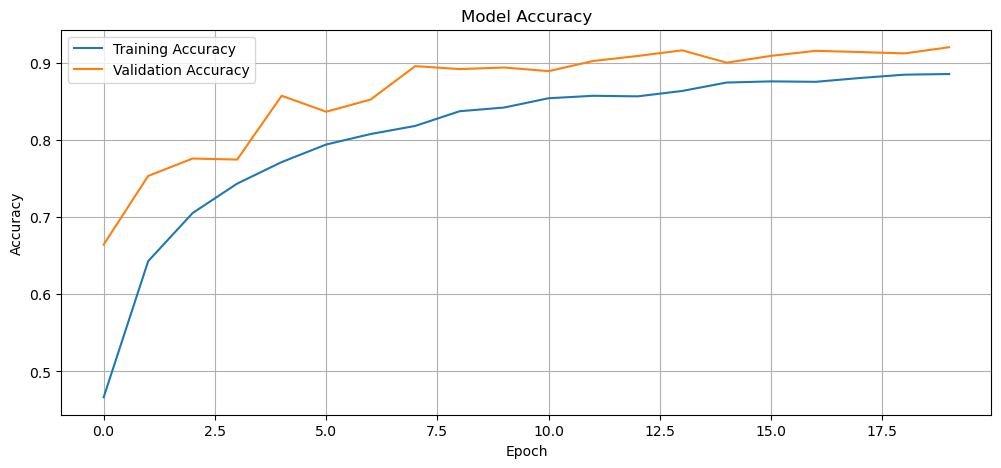

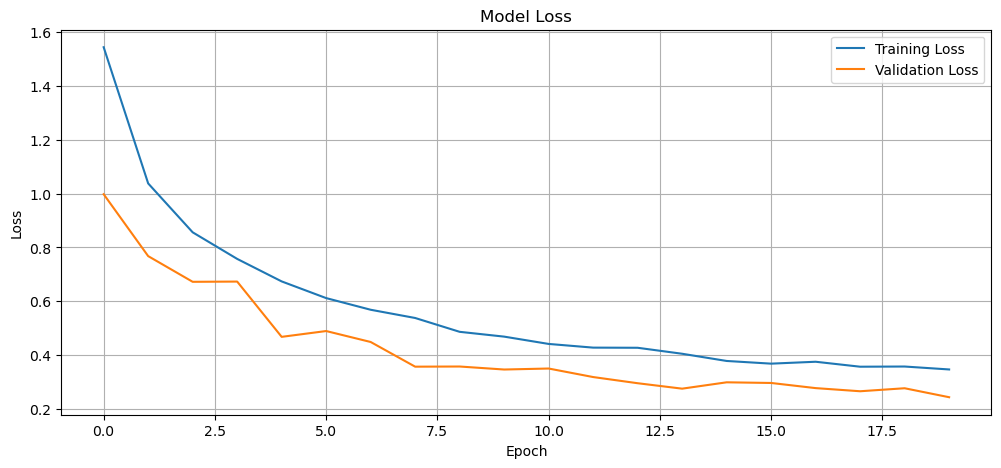

In [8]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot loss
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


In [9]:
# Load the best model
from tensorflow.keras.models import load_model
best_model = load_model("best_model.h5")

# Prepare test generator (reuse ImageDataGenerator)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_generator = test_datagen.flow_from_directory(
    os.path.join(dataset_path, 'imgs'),
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False  # No shuffling for test data
)

# Evaluate the model
test_predictions = best_model.predict(test_generator)


Found 102150 images belonging to 2 classes.
3193/3193 ━━━━━━━━━━━━━━━━━━━━ 1722s 539ms/step


In [12]:
import os
import pandas as pd
import numpy as np

# Map indices (0-9) to labels (c0-c9)
class_labels = {i: f"c{i}" for i in range(10)}  # Explicit mapping
predicted_labels = [class_labels[idx] for idx in np.argmax(test_predictions, axis=1)]  # Map predicted indices to labels

# Extract filenames from the test generator
test_filenames = test_generator.filenames

# Create a DataFrame for submission
submission_df = pd.DataFrame({
    'img': [os.path.basename(filename) for filename in test_filenames],  # Extract image names
    'label': predicted_labels
})

# Save to CSV
submission_path = os.path.join(dataset_path, 'Result', 'submission.csv')
os.makedirs(os.path.dirname(submission_path), exist_ok=True)
submission_df.to_csv(submission_path, index=False)
print(f"Submission file saved to: {submission_path}")


Submission file saved to: C:\Users\Aavneet Singh Johar\IIT_Kanpur_Edvancer\Python\Deep Learning projects\Project 4\state-farm-distracted-driver-detection\Result\submission.csv
